## **Exploratory Data Analysis for Norwegian Catch Data (Fangstdata) Datasets 2020-2024**
Big Data Analysis using PySpark and pandas

All bruk av data fra Fiskeridirektoratet er underlagt Norsk lisens for offentlige data (NLOD).<br>
**Kilde (data source):** Fiskeridirektoratet

### **Loading in the data with PySpark**

In [107]:
# Importing necessary libraries
import time as time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.font_manager
import numpy as np

custom_params = {'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.spines.left': True,
                'axes.spines.bottom': True,
                'font.family': 'Arial'
}
sns.set_theme(style='ticks', rc=custom_params)

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType, LongType, TimestampType
from pyspark.sql.functions import col, sum, countDistinct, count, regexp_replace, split, month, year, size, element_at, struct, trim, avg, expr, lit, to_date, first, concat_ws
from pyspark.sql import functions as F 
from pyspark.sql.window import Window

In [108]:
# Create SparkSession
spark = SparkSession.builder.appName('Fangstdata').getOrCreate()

In [109]:
# Read a sample of the data to infer schema
sample_df = spark.read.option("delimiter", ";").csv('fangstdata_2020.csv', header=True, inferSchema=True)

inferred_schema = sample_df.schema

In [110]:
# Defining the schema from this
inferred_schema

StructType([StructField('Dokumentnummer', LongType(), True), StructField('Dokumenttype (kode)', IntegerType(), True), StructField('Dokumenttype', StringType(), True), StructField('Dokument versjonsnummer', IntegerType(), True), StructField('Dokument salgsdato', StringType(), True), StructField('Dokument versjonstidspunkt', StringType(), True), StructField('Salgslag ID', IntegerType(), True), StructField('Salgslag (kode)', IntegerType(), True), StructField('Salgslag', StringType(), True), StructField('Mottaker ID', IntegerType(), True), StructField('Mottakernasjonalitet (kode)', StringType(), True), StructField('Mottakernasjonalitet', StringType(), True), StructField('Mottaksstasjon', StringType(), True), StructField('Landingskommune (kode)', IntegerType(), True), StructField('Landingskommune', StringType(), True), StructField('Landingsfylke (kode)', IntegerType(), True), StructField('Landingsfylke', StringType(), True), StructField('Landingsnasjon (kode)', StringType(), True), StructFi

In [111]:
# Define the schema
schema = StructType([
    StructField('Dokumentnummer', LongType(), True),
    StructField('Dokumenttype (kode)', IntegerType(), True),
    StructField('Dokumenttype', StringType(), True),
    StructField('Dokument versjonsnummer', IntegerType(), True),
    StructField('Dokument salgsdato', StringType(), True),
    StructField('Dokument versjonstidspunkt', StringType(), True),
    StructField('Salgslag ID', IntegerType(), True),
    StructField('Salgslag (kode)', IntegerType(), True),
    StructField('Salgslag', StringType(), True),
    StructField('Mottaker ID', IntegerType(), True),
    StructField('Mottakernasjonalitet (kode)', StringType(), True),
    StructField('Mottakernasjonalitet', StringType(), True),
    StructField('Mottaksstasjon', StringType(), True),
    StructField('Landingskommune (kode)', IntegerType(), True),
    StructField('Landingskommune', StringType(), True),
    StructField('Landingsfylke (kode)', IntegerType(), True),
    StructField('Landingsfylke', StringType(), True),
    StructField('Landingsnasjon (kode)', StringType(), True),
    StructField('Landingsnasjon', StringType(), True),
    StructField('Produksjonsanlegg', StringType(), True),
    StructField('Produksjonskommune (kode)', IntegerType(), True),
    StructField('Produksjonskommune', StringType(), True),
    StructField('Mottakende fartøy reg.merke', StringType(), True),
    StructField('Mottakende fartøy rkal', StringType(), True),
    StructField('Mottakende fartøytype (kode)', IntegerType(), True),
    StructField('Mottakende fart.type', StringType(), True),
    StructField('Mottakende fartøynasj. (kode)', StringType(), True),
    StructField('Mottakende fart.nasj', StringType(), True),
    StructField('Fisker ID', IntegerType(), True),
    StructField('Fiskerkommune (kode)', IntegerType(), True),
    StructField('Fiskerkommune', StringType(), True),
    StructField('Fiskernasjonalitet (kode)', StringType(), True),
    StructField('Fiskernasjonalitet', StringType(), True),
    StructField('Fartøy ID', IntegerType(), True),
    StructField('Registreringsmerke (seddel)', StringType(), True),
    StructField('Radiokallesignal (seddel)', StringType(), True),
    StructField('Fartøynavn', StringType(), True),
    StructField('Fartøytype (kode)', IntegerType(), True),
    StructField('Fartøytype', StringType(), True),
    StructField('Kvotefartøy reg.merke', StringType(), True),
    StructField('Besetning', IntegerType(), True),
    StructField('Fartøykommune (kode)', IntegerType(), True),
    StructField('Fartøykommune', StringType(), True),
    StructField('Fartøyfylke (kode)', IntegerType(), True),
    StructField('Fartøyfylke', StringType(), True),
    StructField('Fartøynasjonalitet (kode)', StringType(), True),
    StructField('Fartøynasjonalitet', StringType(), True),
    StructField('Fartøynasjonalitet gruppe', StringType(), True),
    StructField('Største lengde', StringType(), True),
    StructField('Lengdegruppe (kode)', IntegerType(), True),
    StructField('Lengdegruppe', StringType(), True),
    StructField('Bruttotonnasje 1969', IntegerType(), True),
    StructField('Bruttotonnasje annen', IntegerType(), True),
    StructField('Byggeår', IntegerType(), True),
    StructField('Ombyggingsår', IntegerType(), True),
    StructField('Motorkraft', IntegerType(), True),
    StructField('Motorbyggeår', IntegerType(), True),
    StructField('Fangstår', IntegerType(), True),
    StructField('Siste fangstdato', StringType(), True),
    StructField('Kvotetype (kode)', IntegerType(), True),
    StructField('Kvotetype', StringType(), True),
    StructField('Redskap (kode)', IntegerType(), True),
    StructField('Redskap', StringType(), True),
    StructField('Redskap - gruppe (kode)', IntegerType(), True),
    StructField('Redskap - gruppe', StringType(), True),
    StructField('Redskap - hovedgruppe (kode)', IntegerType(), True),
    StructField('Redskap - hovedgruppe', StringType(), True),
    StructField('Fangstfelt (kode)', IntegerType(), True),
    StructField('Kyst/hav (kode)', IntegerType(), True),
    StructField('Hovedområde (kode)', IntegerType(), True),
    StructField('Hovedområde', StringType(), True),
    StructField('Lon (hovedområde)', StringType(), True),
    StructField('Lat (hovedområde)', StringType(), True),
    StructField('Lokasjon (kode)', IntegerType(), True),
    StructField('Lon (lokasjon)', StringType(), True),
    StructField('Lat (lokasjon)', StringType(), True),
    StructField('Sone (kode)', StringType(), True),
    StructField('Sone', StringType(), True),
    StructField('Områdegruppering (kode)', StringType(), True),
    StructField('Områdegruppering', StringType(), True),
    StructField('Hovedområde FAO (kode)', IntegerType(), True),
    StructField('Hovedområde FAO', StringType(), True),
    StructField('Nord/sør for 62 grader nord', StringType(), True),
    StructField('Fangstdagbok (nummer)', IntegerType(), True),
    StructField('Fangstdagbok (turnummer)', IntegerType(), True),
    StructField('Landingsdato', StringType(), True),
    StructField('Landingsklokkeslett', TimestampType(), True),
    StructField('Landingsmåned (kode)', IntegerType(), True),
    StructField('Landingsmåned', StringType(), True),
    StructField('Landingstidspunkt', StringType(), True),
    StructField('Dellanding (signal)', IntegerType(), True),
    StructField('Neste mottaksstasjon', StringType(), True),
    StructField('Forrige mottakstasjon', StringType(), True),
    StructField('Linjenummer', IntegerType(), True),
    StructField('Art - FDIR (kode)', IntegerType(), True),
    StructField('Art - FDIR', StringType(), True),
    StructField('Art (kode)', IntegerType(), True),
    StructField('Art', StringType(), True),
    StructField('Art - gruppe (kode)', IntegerType(), True),
    StructField('Art - gruppe', StringType(), True),
    StructField('Art - hovedgruppe (kode)', IntegerType(), True),
    StructField('Art - hovedgruppe', StringType(), True),
    StructField('Art FAO (kode)', StringType(), True),
    StructField('Art FAO', StringType(), True),
    StructField('Produkttilstand (kode)', IntegerType(), True),
    StructField('Produkttilstand', StringType(), True),
    StructField('Konserveringsmåte (kode)', IntegerType(), True),
    StructField('Konserveringsmåte', StringType(), True),
    StructField('Landingsmåte (kode)', IntegerType(), True),
    StructField('Landingsmåte', StringType(), True),
    StructField('Kvalitet (kode)', IntegerType(), True),
    StructField('Kvalitet', StringType(), True),
    StructField('Størrelsesgruppering (kode)', IntegerType(), True),
    StructField('Anvendelse (kode)', IntegerType(), True),
    StructField('Anvendelse', StringType(), True),
    StructField('Anvendelse hovedgruppe (kode)', IntegerType(), True),
    StructField('Anvendelse hoved gruppe', StringType(), True),
    StructField('Antall stykk', IntegerType(), True),
    StructField('Bruttovekt', StringType(), True),
    StructField('Produktvekt', StringType(), True),
    StructField('Produktvekt over kvote', StringType(), True),
    StructField('Rundvekt over kvote', StringType(), True),
    StructField('Rundvekt', StringType(), True),
    StructField('Enhetspris for kjøper', StringType(), True),
    StructField('Beløp for kjøper', StringType(), True),
    StructField('Enhetspris for fisker', StringType(), True),
    StructField('Beløp for fisker', StringType(), True),
    StructField('Støttebeløp', IntegerType(), True),
    StructField('Lagsavgift', StringType(), True),
    StructField('Inndradd fangstverdi', StringType(), True),
    StructField('Etterbetaling', StringType(), True),
    StructField('Fangstverdi', StringType(), True),
    StructField('Oppdateringstidspunkt', StringType(), True)
])

'LongType and TimestampType' were not previously defined. It was therefore important to define the schema beforehand to ensure correct formatting and reading before loading the csv files.

In [112]:
# Start the timer
start_time = time.time()

# Load each year's "fangstdata", with a csv separator ";"
df_2020 = spark.read.csv('fangstdata_2020.csv', sep=';', header=True, schema=schema)
df_2021 = spark.read.csv('fangstdata_2021.csv', sep=';', header=True, schema=schema)
df_2022 = spark.read.csv('fangstdata_2022.csv', sep=';', header=True, schema=schema)
df_2023 = spark.read.csv('fangstdata_2023.csv', sep=';', header=True, schema=schema)
df_2024 = spark.read.csv('fangstdata_2024.csv', sep=';', header=True, schema=schema)

# End the timer
end_time = time.time()

execution_time = end_time - start_time

# Print the execution time
print(f'Loading in the data using PySpark took {execution_time:.3f} seconds.')

Loading in the data using PySpark took 0.152 seconds.


In [113]:
# Combining the DataFrames into one
combined_df = df_2020.union(df_2021).union(df_2022).union(df_2023).union(df_2024)

In [114]:
# Checking shape of DataFrame
print(f'Shape: ({combined_df.count()}, {len(combined_df.columns)})')

Shape: (4932203, 133)


In [115]:
# Removing duplicates
df = combined_df.distinct().cache()

In [116]:
# Checking shape after removing duplicates

# Count the number of rows
num_rows = df.count()

# Count the number of columns
num_columns = len(df.columns)

print(f'Shape: ({num_rows}, {num_columns})')

Shape: (4932203, 133)


We are working with 4,932,203 rows and 133 columns. We have combined all the datasets from years 2020-2024, and removed potential duplicates. None were detected.

In [117]:
df.show(10)

+--------------+-------------------+-------------------+-----------------------+------------------+--------------------------+-----------+---------------+--------------------+-----------+---------------------------+--------------------+--------------+----------------------+---------------+--------------------+-------------+---------------------+--------------+-----------------+-------------------------+------------------+---------------------------+----------------------+----------------------------+--------------------+-----------------------------+--------------------+---------+--------------------+-------------+-------------------------+------------------+----------+---------------------------+-------------------------+----------------+-----------------+--------------------+---------------------+---------+--------------------+-------------+------------------+---------------+-------------------------+------------------+-------------------------+--------------+-------------------+----

### **Data exploration and cleaning**

In [118]:
# Displaying all columns so we can scroll through the entire dataset horizontally
pd.options.display.max_columns=133

In [119]:
# Displaying the dataframe in Pandas for convenience
df.limit(6).toPandas()

,Dokumentnummer,Dokumenttype (kode),Dokumenttype,Dokument versjonsnummer,Dokument salgsdato,Dokument versjonstidspunkt,Salgslag ID,Salgslag (kode),Salgslag,Mottaker ID,Mottakernasjonalitet (kode),Mottakernasjonalitet,Mottaksstasjon,Landingskommune (kode),Landingskommune,Landingsfylke (kode),Landingsfylke,Landingsnasjon (kode),Landingsnasjon,Produksjonsanlegg,Produksjonskommune (kode),Produksjonskommune,Mottakende fartøy reg.merke,Mottakende fartøy rkal,Mottakende fartøytype (kode),Mottakende fart.type,Mottakende fartøynasj. (kode),Mottakende fart.nasj,Fisker ID,Fiskerkommune (kode),Fiskerkommune,Fiskernasjonalitet (kode),Fiskernasjonalitet,Fartøy ID,Registreringsmerke (seddel),Radiokallesignal (seddel),Fartøynavn,Fartøytype (kode),Fartøytype,Kvotefartøy reg.merke,Besetning,Fartøykommune (kode),Fartøykommune,Fartøyfylke (kode),Fartøyfylke,Fartøynasjonalitet (kode),Fartøynasjonalitet,Fartøynasjonalitet gruppe,Største lengde,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Byggeår,Ombyggingsår,Motorkraft,Motorbyggeår,Fangstår,Siste fangstdato,Kvotetype (kode),Kvotetype,Redskap (kode),Redskap,Redskap - gruppe (kode),Redskap - gruppe,Redskap - hovedgruppe (kode),Redskap - hovedgruppe,Fangstfelt (kode),Kyst/hav (kode),Hovedområde (kode),Hovedområde,Lon (hovedområde),Lat (hovedområde),Lokasjon (kode),Lon (lokasjon),Lat (lokasjon),Sone (kode),Sone,Områdegruppering (kode),Områdegruppering,Hovedområde FAO (kode),Hovedområde FAO,Nord/sør for 62 grader nord,Fangstdagbok (nummer),Fangstdagbok (turnummer),Landingsdato,Landingsklokkeslett,Landingsmåned (kode),Landingsmåned,Landingstidspunkt,Dellanding (signal),Neste mottaksstasjon,Forrige mottakstasjon,Linjenummer,Art - FDIR (kode),Art - FDIR,Art (kode),Art,Art - gruppe (kode),Art - gruppe,Art - hovedgruppe (kode),Art - hovedgruppe,Art FAO (kode),Art FAO,Produkttilstand (kode),Produkttilstand,Konserveringsmåte (kode),Konserveringsmåte,Landingsmåte (kode),Landingsmåte,Kvalitet (kode),Kvalitet,Størrelsesgruppering (kode),Anvendelse (kode),Anvendelse,Anvendelse hovedgruppe (kode),Anvendelse hoved gruppe,Antall stykk,Bruttovekt,Produktvekt,Produktvekt over kvote,Rundvekt over kvote,Rundvekt,Enhetspris for kjøper,Beløp for kjøper,Enhetspris for fisker,Beløp for fisker,Støttebeløp,Lagsavgift,Inndradd fangstverdi,Etterbetaling,Fangstverdi,Oppdateringstidspunkt
0,1599128,0,Sluttseddeldokument,4,29.11.2023,"06.12.2023 12.47.47,143000000",951206091,8,Norges Sildesalgslag,NaN,NOR,NORGE,HBRB,9990,None,NaN,None,NOR,NORGE,HBRB,4625,AUSTEVOLL,H 0099AV,LDKM,3,Brønnbåt,NOR,NORGE,985508380,1106,HAUGESUND,NOR,NORGE,2014066694,R 0001H,LG8393,SCOMBRUS,1,Fiskefartøy,R 0001H,NaN,1106,HAUGESUND,11,Rogaland,NOR,NORGE,Norske fartøy,"14,99",2,"11-14,99 m",NaN,NaN,2014,NaN,600,2014,2023,29.11.2023,1,Vanlig kvote,11,Snurpenot/ringnot,1,Not,2,Not,80415,8,4,Vest-Finnmark,"20,8475","70,64731",15,"23,49366","70,11048",NOR,Norges økonomiske sone,27_2_A_2,"Atlanterhavet, nordøst/Norskehavet - utenfor N...",27,Nordøstlige Atlanterhav,Nord for 62°N,0,0,29.11.2023,2024-08-30 04:29:00,11,November,29.11.2023,0,None,None,1,61101,Norsk vårgytende sild,102001,Norsk vårgytende sild,102,"Sild, norsk vårgytende",1,Pelagisk fisk,HER,Sild,110,Rund,11,Rsw,1,i lås,99,Uspesifisert,7350999,211,Frysing konsum eksport,1,Konsum,0,12021,11781,None,None,11781,None,None,None,None,NaN,None,None,None,None,24.08.2024
1,1599057,0,Sluttseddeldokument,4,27.11.2023,"01.12.2023 08.25.09,908000000",951206091,8,Norges Sildesalgslag,NaN,NOR,NORGE,NBRB,9990,None,NaN,None,NOR,NORGE,NBRB,1868,ØKSNES,N 0346Ø,LEPP,3,Brønnbåt,NOR,NORGE,984365756,1573,SMØLA,NOR,NORGE,2015071335,M 0020SM,LG9170,NY-VIKING,1,Fiskefartøy,M 0020SM,NaN,1573,SMØLA,15,Møre og Romsdal,NOR,NORGE,Norske fartøy,"14,95",2,"11-14,99 m",NaN,NaN,2015,NaN,700,2019,2023,27.11.2023,1,Vanlig kvote,11,Snurpenot/ringnot,1,Not,2,Not,80415,8,4,Vest-Finnmark,"20,8475","70,64731",15,"23,49366","70,11048",NOR,Norges økonomiske sone,27_2_A_2,"Atlanterhavet, nordøst/Norskehavet - utenfo

In [120]:
# Checking number of types of catch equipment
df.agg(countDistinct('Redskap')).collect()[0][0]

35

In [121]:
# Checking the species of fish listed
fish_df = df.select('Art FAO').distinct()

fish_unique = fish_df.collect()

# Prints species
for row in fish_unique:
    print(row['Art FAO'])

Snøkrabbe
Sandflyndre
Rødspette
Ål
Brisling
Kongekrabbe
Gressgylt
Skolest
Slettvar
Håbrann
Sanktpetersfisk
Strandsnegl
Berggylt
Bergnebb
Torsk
Blålange
Breiflabb
Fjærehinne uspes
Sandskate
Laks
Smørflyndre
Taskekrabbe
Kveite
Flekksteinbit
Strømsild
Lysing
Pigghå
Lyr
Øyepål
Gapeflyndre
Blekkspruter uspes.
Makrellgjedde
Hyse
Skjellbrosme
Knurr
Various squids nei *
Spinytail skate *
Sei
Hvitting
Kongsnegl (Kongesnegl)
Tunge
Andre pigghuder
Haneskjell
Annen flyndre
Glassvar
Antarktisk krill
Piggskate
Vassild
Spisskate
Andre brunalger
Sjøpiggsvin uspes.
Snabeluer
Makrell
Sjøkreps
Strømsild/Vassild
Sild
Kolmule
Lomre
Skrubbe
Tobis og annen sil
Gulringskate
Lange
Brosme
Stortare
Hvitskate
Havål
Havabbor
Akkar
Hummer
Grisetangdokke
Annen skate og rokke
Trollkrabbe
Dypvannsreke
Gråsteinbit
Trompetfisk
Svarthå
Rognkjeks (felles)
Kamskjell
Annen marin fisk
Blåsteinbit
Makrellstørje
Blåkveite
Uer uspes.
Havmus
Grønngylt
Uer (vanlig)
Piggvar
Isgalt
Kloskate
Kamskjell uspes.
Skate, uspesifisert
Sølv

In [122]:
# Checking the amount of months codes listed (should be 12)
df.agg(countDistinct('Landingsmåned (kode)')).collect()[0][0]

13

In [123]:
# Get distinct values for the column
unique_values_df = df.select('Landingsmåned (kode)').distinct()

# Collecting the distinct values into a list
unique_values = unique_values_df.collect()

# Prints codes
for row in unique_values:
    print(row['Landingsmåned (kode)'])

12
1
13
6
3
5
9
4
8
7
10
11
2


Landingsmåned code = 13 means it was delivered the next year, in January

In [124]:
# Selecting specific columns
filtered = df.filter(df['Landingsmåned (kode)'] == 13)

# Showing specific columns
filtered.select('Landingsmåned (kode)', 'Landingsmåned').show(5)

+--------------------+--------------------+
|Landingsmåned (kode)|       Landingsmåned|
+--------------------+--------------------+
|                  13|Levert påfølgende år|
|                  13|Levert påfølgende år|
|                  13|Levert påfølgende år|
|                  13|Levert påfølgende år|
|                  13|Levert påfølgende år|
+--------------------+--------------------+
only showing top 5 rows



#### **Removing whitespace**

In [125]:
# Get distinct values for the column
unique_values_df = df.select('Landingsmåned').distinct()

# Collecting the distinct values into a list
unique_values = unique_values_df.collect()

for row in unique_values:
    print(row)

Row(Landingsmåned='Juli     ')
Row(Landingsmåned='August   ')
Row(Landingsmåned='November')
Row(Landingsmåned='Februar')
Row(Landingsmåned='Juni     ')
Row(Landingsmåned='Levert påfølgende år')
Row(Landingsmåned='Juli')
Row(Landingsmåned='Oktober')
Row(Landingsmåned='Mars')
Row(Landingsmåned='Mars     ')
Row(Landingsmåned='August')
Row(Landingsmåned='April')
Row(Landingsmåned='Januar   ')
Row(Landingsmåned='Desember ')
Row(Landingsmåned='Februar  ')
Row(Landingsmåned='Mai      ')
Row(Landingsmåned='Januar')
Row(Landingsmåned='April    ')
Row(Landingsmåned='Mai')
Row(Landingsmåned='November ')
Row(Landingsmåned='Desember')
Row(Landingsmåned='Oktober  ')
Row(Landingsmåned='September')
Row(Landingsmåned='Juni')


We update the Landingsmåned columns by stripping ("trimming" in PySpark) the strings to remove whitespace

In [126]:
# Trims the whitespace from the string columns
df = df.withColumn('Landingsmåned', trim(col('Landingsmåned')))

# Counts the unique values in column
df.agg(countDistinct('Landingsmåned')).collect()[0][0]

13

In [127]:
# Get distinct values for the column
unique_values_df = df.select('Landingsmåned').distinct()

# Collecting the distinct values into a list
unique_values = unique_values_df.collect()

for row in unique_values:
    print(row)

Row(Landingsmåned='November')
Row(Landingsmåned='Februar')
Row(Landingsmåned='Levert påfølgende år')
Row(Landingsmåned='Juli')
Row(Landingsmåned='Oktober')
Row(Landingsmåned='Mars')
Row(Landingsmåned='August')
Row(Landingsmåned='April')
Row(Landingsmåned='Januar')
Row(Landingsmåned='Mai')
Row(Landingsmåned='Desember')
Row(Landingsmåned='September')
Row(Landingsmåned='Juni')


Next, we want to get familiar with other columns and their value types. Let's make sure all the years have been included in the 'Fangstår' columns.

In [128]:
# Counts the unique values in column (should be 5 as I'm working with catch over 5 years)
df.agg(countDistinct('Fangstår')).collect()[0][0]

5

Certain numbers have been loaded as strings. These have to be converted into int/float types prior to analysis.

In [129]:
# Checking type for column values
df.select('Fangstår', 'Landingsmåned', 'Fangstverdi', 'Rundvekt')

DataFrame[Fangstår: int, Landingsmåned: string, Fangstverdi: string, Rundvekt: string]

### **Keeping columns of interest**

"Landingsmåned" refers to the month the catch has been brought to land, so catch date/Siste fangstdato should be used when calculating the total revenue.<br>
Many entries for Fangstverdi (total revenue) = NULL. The data documentation at https://www.fiskeridir.no/Tall-og-analyse/AApne-data/Fangstdata-seddel-koblet-med-fartoeydata states revenue generated the last 12 months is sensitive information. This explains why data from 2024 and fall 2023 is missing. Total revenue is available only for the years prior to 2023.

In [130]:
# Check the schema
df.printSchema()

root
 |-- Dokumentnummer: long (nullable = true)
 |-- Dokumenttype (kode): integer (nullable = true)
 |-- Dokumenttype: string (nullable = true)
 |-- Dokument versjonsnummer: integer (nullable = true)
 |-- Dokument salgsdato: string (nullable = true)
 |-- Dokument versjonstidspunkt: string (nullable = true)
 |-- Salgslag ID: integer (nullable = true)
 |-- Salgslag (kode): integer (nullable = true)
 |-- Salgslag: string (nullable = true)
 |-- Mottaker ID: integer (nullable = true)
 |-- Mottakernasjonalitet (kode): string (nullable = true)
 |-- Mottakernasjonalitet: string (nullable = true)
 |-- Mottaksstasjon: string (nullable = true)
 |-- Landingskommune (kode): integer (nullable = true)
 |-- Landingskommune: string (nullable = true)
 |-- Landingsfylke (kode): integer (nullable = true)
 |-- Landingsfylke: string (nullable = true)
 |-- Landingsnasjon (kode): string (nullable = true)
 |-- Landingsnasjon: string (nullable = true)
 |-- Produksjonsanlegg: string (nullable = true)
 |-- Produ

In [131]:
# Columns to select
cols = ['Fartøynavn', 
        'Fartøytype', 
        'Fartøykommune', 
        'Fartøyfylke', 
        'Byggeår', 
        'Motorkraft', 
        'Motorbyggeår', 
        'Redskap',
        'Fangstår', 
        'Siste fangstdato', 
        'Fangstverdi', 
        'Hovedområde',
        'Rundvekt',
        'Art FAO',
        'Enhetspris for fisker']

# Selecting specific columns
filtered = df.select(cols)

In [132]:
# Check if the column selection is correct
filtered.limit(6).toPandas()

,Fartøynavn,Fartøytype,Fartøykommune,Fartøyfylke,Byggeår,Motorkraft,Motorbyggeår,Redskap,Fangstår,Siste fangstdato,Fangstverdi,Hovedområde,Rundvekt,Art FAO,Enhetspris for fisker
0,SCOMBRUS,Fiskefartøy,HAUGESUND,Rogaland,2014,600,2014,Snurpenot/ringnot,2023,29.11.2023,None,Vest-Finnmark,11781,Sild,None
1,NY-VIKING,Fiskefartøy,SMØLA,Møre og Romsdal,2015,700,2019,Snurpenot/ringnot,2023,27.11.2023,None,Vest-Finnmark,18369,Sild,None
2,GLESEN,Fiskefartøy,AUSTEVOLL,Vestland,2016,427,2016,Snurpenot/ringnot,2023,07.11.2023,None,Vest-Finnmark,5547,Sild,None
3,LAURA,Fiskefartøy,BERGEN,Vestland,2021,370,2021,Snurpenot/ringnot,2023,21.11.2023,None,Vest-Finnmark,1467,Sild,None
4,HYDRA,Fiskefartøy,NÆRØYSUND,Trøndelag,2017,625,2018,Snurpenot/ringnot,2023,02.12.2023,None,Vest-Finnmark,11251,Sild,None
5,LEKAMØY,Fiskefartøy,LEKA,Trøndelag,2009,152,2009,Snurpenot/ringnot,2023,09.11.2023,None,Vest-Finnmark,1520,Sild,None


#### **How many null values do we have in the dataframe?**

In [133]:
# Counts the null values
null_counts = filtered.select([sum(col(column).isNull().cast('int')).alias(column) for column in filtered.columns])

# Display the null counts
null_counts.limit(6).toPandas()

,Fartøynavn,Fartøytype,Fartøykommune,Fartøyfylke,Byggeår,Motorkraft,Motorbyggeår,Redskap,Fangstår,Siste fangstdato,Fangstverdi,Hovedområde,Rundvekt,Art FAO,Enhetspris for fisker
0,265058,0,265058,265058,266413,268456,276499,0,0,0,1084559,0,10,164,1084593


In [134]:
# Showing the null values for 'Rundvekt'
rundvekt = df.filter(col('Rundvekt').isNull()).show()

+--------------+-------------------+-------------------+-----------------------+------------------+--------------------------+-----------+---------------+--------------------+-----------+---------------------------+--------------------+--------------+----------------------+---------------+--------------------+-------------+---------------------+--------------+-----------------+-------------------------+------------------+---------------------------+----------------------+----------------------------+--------------------+-----------------------------+--------------------+---------+--------------------+-------------+-------------------------+------------------+----------+---------------------------+-------------------------+----------+-----------------+-----------+---------------------+---------+--------------------+-------------+------------------+-----------+-------------------------+------------------+-------------------------+--------------+-------------------+-------------+---------

In [135]:
# Keeping for data analysis from all Norwegian vessels
df_norway = df

# Dropping columns with missing values as the vessels we are interested in will have this information listed
df = filtered.na.drop(subset=['Fartøynavn', 'Rundvekt', 'Motorbyggeår', 'Motorkraft', 'Byggeår', 'Art FAO'])

In [136]:
# Double check that no values are missing
df.select([sum(col(column).isNull().cast('int')).alias(column) for column in filtered.columns]).limit(6).toPandas()

,Fartøynavn,Fartøytype,Fartøykommune,Fartøyfylke,Byggeår,Motorkraft,Motorbyggeår,Redskap,Fangstår,Siste fangstdato,Fangstverdi,Hovedområde,Rundvekt,Art FAO,Enhetspris for fisker
0,0,0,0,0,0,0,0,0,0,0,1011269,0,0,0,1011303


The number of null values in 'Fangstverdi' (total revenue) and 'Enhetspris for fisker' (fish unit price) makes sense, as a lot of the data from 2024 (n=720 685) and 2023 is sensitive information.
According to the documentation, the Rundvekt = 0 when biproducts are considered.

In [137]:
# Check if 'Rundvekt' has no null values
df.filter(col('Rundvekt').isNull()).count()

0

In [138]:
# Check if there are only integers or double types
df.select('Rundvekt').distinct().show(truncate=False)

+--------+
|Rundvekt|
+--------+
|33,35   |
|675     |
|691     |
|296     |
|1512    |
|439,5   |
|380,65  |
|186,2   |
|3,24    |
|41,5    |
|861,3   |
|18306   |
|3982,8  |
|16,88   |
|14,76   |
|6194    |
|4032    |
|105344  |
|17578,98|
|5144,85 |
+--------+
only showing top 20 rows



In [139]:
# Check if there are only integers or double types
df.select('Fangstverdi').distinct().show(truncate=False)

+-----------+
|Fangstverdi|
+-----------+
|26854,24   |
|14,76      |
|296        |
|7711       |
|5022,5     |
|11662,2    |
|7738,29    |
|46,23      |
|3210       |
|1512       |
|7252       |
|1572       |
|16320      |
|3414       |
|675        |
|20782,8    |
|35640      |
|2136       |
|10,28      |
|47880      |
+-----------+
only showing top 20 rows



#### **Coverting values to correct formats**



In [140]:
# Converts dates to DateType
df = df.withColumn('Siste fangstdato', to_date(col('Siste fangstdato'), 'dd.MM.yyyy'))

# Converts strings with numbers to double and replace ',' in values to '.' so PySpark can recognize them as float values ('double' in PySpark)
df = df.withColumn(
    'Fangstverdi', regexp_replace(col('Fangstverdi'), ',', '.').cast('double')).withColumn(
    'Rundvekt', regexp_replace(col('Rundvekt'), ',', '.').cast('double')).withColumn(
    'Enhetspris for fisker', regexp_replace(col('Enhetspris for fisker'), ',', '.').cast('double'))

# Adding month column
df = df.withColumn('Fangstmåned', month(col('Siste fangstdato')))

# Checks if schema format is correct
df.printSchema()

root
 |-- Fartøynavn: string (nullable = true)
 |-- Fartøytype: string (nullable = true)
 |-- Fartøykommune: string (nullable = true)
 |-- Fartøyfylke: string (nullable = true)
 |-- Byggeår: integer (nullable = true)
 |-- Motorkraft: integer (nullable = true)
 |-- Motorbyggeår: integer (nullable = true)
 |-- Redskap: string (nullable = true)
 |-- Fangstår: integer (nullable = true)
 |-- Siste fangstdato: date (nullable = true)
 |-- Fangstverdi: double (nullable = true)
 |-- Hovedområde: string (nullable = true)
 |-- Rundvekt: double (nullable = true)
 |-- Art FAO: string (nullable = true)
 |-- Enhetspris for fisker: double (nullable = true)
 |-- Fangstmåned: integer (nullable = true)



In [141]:
# Double check there are no null values
df.filter(col('Rundvekt').isNull()).count()

0

In [142]:
df.show(5)

+----------+-----------+-------------+---------------+-------+----------+------------+-----------------+--------+----------------+-----------+-------------+--------+-------+---------------------+-----------+
|Fartøynavn| Fartøytype|Fartøykommune|    Fartøyfylke|Byggeår|Motorkraft|Motorbyggeår|          Redskap|Fangstår|Siste fangstdato|Fangstverdi|  Hovedområde|Rundvekt|Art FAO|Enhetspris for fisker|Fangstmåned|
+----------+-----------+-------------+---------------+-------+----------+------------+-----------------+--------+----------------+-----------+-------------+--------+-------+---------------------+-----------+
|  SCOMBRUS|Fiskefartøy|    HAUGESUND|       Rogaland|   2014|       600|        2014|Snurpenot/ringnot|    2023|      2023-11-29|       NULL|Vest-Finnmark| 11781.0|   Sild|                 NULL|         11|
| NY-VIKING|Fiskefartøy|        SMØLA|Møre og Romsdal|   2015|       700|        2019|Snurpenot/ringnot|    2023|      2023-11-27|       NULL|Vest-Finnmark| 18369.0|   

In [144]:
# Counts the number of vessels in our dataset
total_vessel_count = df.agg(countDistinct(col('Fartøynavn'))).collect()[0][0]

print(f'There are {total_vessel_count} registered vessels in the dataset.')

There are 5360 registered vessels in the dataset.


### **Data analysis**

Some interesting questions:

**Area-based:**
- In which area/'Hovedområde' are the most fish caught?
- Do the vessels that catch the most visit those areas the most often?

**Time based:**
- Does activity during certain months produce higher rundvekt?
- Have certain years been more lucrative?

**Revenue and rundvekt:**
- Which vessels catch the most fish?
- Does catching the most correlate with having the highest revenue?
- Which vessels have the highest unit price per species of fish?
    - Does the higher unit price also mean their total revenue is higher?

**Fish species:**
- Which vessels catch the most of each species of fish?

#### **Focusing on Herøy kommune**

In [145]:
# Filter for vessels only in Herøy kommune
municipality = df.filter((col('Fartøykommune') == 'HERØY i Møre og Romsdal'))

# Count the vessels in Herøy
count_vessels = municipality.agg(countDistinct('Fartøynavn')).collect()[0][0]

# Count the vessels in Herøy
print(f'There are {count_vessels} vessels in Herøy.')

There are 105 vessels in Herøy.


In [146]:
# Create a DataFrame with total values per month and year for every vessel
df_overview = municipality.groupBy('Fangstår', 'Fangstmåned', 'Fartøynavn', 'Art FAO', 'Hovedområde', 'Enhetspris for fisker').agg(
    count('Hovedområde').alias('Besøk'),
    sum('Rundvekt').alias('Total rundvekt'),
    sum('Fangstverdi').alias('Total fangstverdi'),
)

In [147]:
# Ensure there are no null values in 'Total rundvekt' after aggregation
df_overview.filter(col('Total rundvekt').isNull()).count()

0

In [148]:
# Converting the overview PySpark DataFrame to a pandas DataFrame
df_overview_pandas = df_overview.toPandas()

df_overview.show(5)


+--------+-----------+----------+------------+--------------------+---------------------+-----+------------------+-----------------+
|Fangstår|Fangstmåned|Fartøynavn|     Art FAO|         Hovedområde|Enhetspris for fisker|Besøk|    Total rundvekt|Total fangstverdi|
+--------+-----------+----------+------------+--------------------+---------------------+-----+------------------+-----------------+
|    2022|          4|     STINA|       Torsk|       Vest-Finnmark|                 33.0|   76|           67203.0|        1478466.0|
|    2022|         10|    SIGNAL|      Brosme|Storegga-Frøyabanken|                 12.0|    5|102.19999999999999|            876.0|
|    2020|          4|     FLUMA|         Lyr|Storegga-Frøyabanken|                 12.0|    1|            118.45|           1236.0|
|    2021|          6|   SMARAGD|        Sild|     Eigersundbanken|                 5.88|    3|          366674.0|        2156043.0|
|    2023|          8| LEINEBRIS|Uer (vanlig)|            Bjørnøya|  

##### **Which vessels in Herøy have caught the most fish?**

In [149]:
# Group by 'Fartøynavn' and sum the total amount of 'Total rundvekt' across all months
grouped_df = df_overview.groupBy('Fartøynavn').agg(sum('Total rundvekt').alias('Total rundvekt'))

# Order the 'Fartøynavn' by 'Total rundvekt' and limit to the top 20 values
top_20_df = grouped_df.sort(col('Total rundvekt').desc()).limit(20)

# Convert PySpark DataFrame to a pandas DataFrame for seaborn plotting
pandas_df = top_20_df.toPandas()

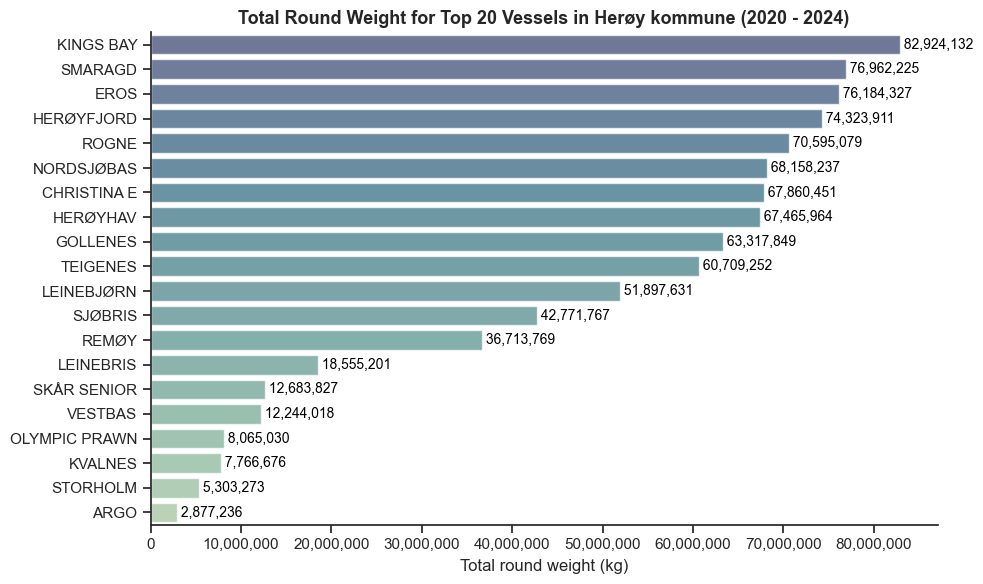

In [150]:
# Create a horizontal bar chart for total catch (Rundvekt)
plt.figure(figsize=(10,6))
sns.barplot(data=pandas_df, y='Fartøynavn', x='Total rundvekt', hue='Fartøynavn', palette='crest_r', alpha=0.7)

# Customize tick labels to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Adding
for index, value in enumerate(pandas_df['Total rundvekt']):
    plt.text(value, index, f' {value:,.0f}', ha='left', va='center', color='black', fontsize=10)

# Labels and titles
plt.title('Total Round Weight for Top 20 Vessels in Herøy kommune (2020 - 2024)', fontdict={'fontsize' : 13, 'fontweight':'semibold'})
plt.ylabel('')
plt.xlabel('Total round weight (kg)', labelpad=5)

plt.tight_layout()

Let's also check the revenue (although the last 12 months will be missing)

In [151]:
# Group by 'Fartøynavn' and sum the total amount of 'Total fangstverdi' across all months
grouped_revenue = df_overview.groupBy('Fartøynavn').agg(sum('Total fangstverdi').alias('Total fangstverdi'))

# Order the 'Fartøynavn' by 'Total fangstverdi' and limit to the top 20 values
top_20_revenue = grouped_revenue.sort(col('Total fangstverdi').desc()).limit(20)

# Convert PySpark DataFrame to a pandas DataFrame for seaborn plotting
pandas_revenue = top_20_revenue.toPandas()

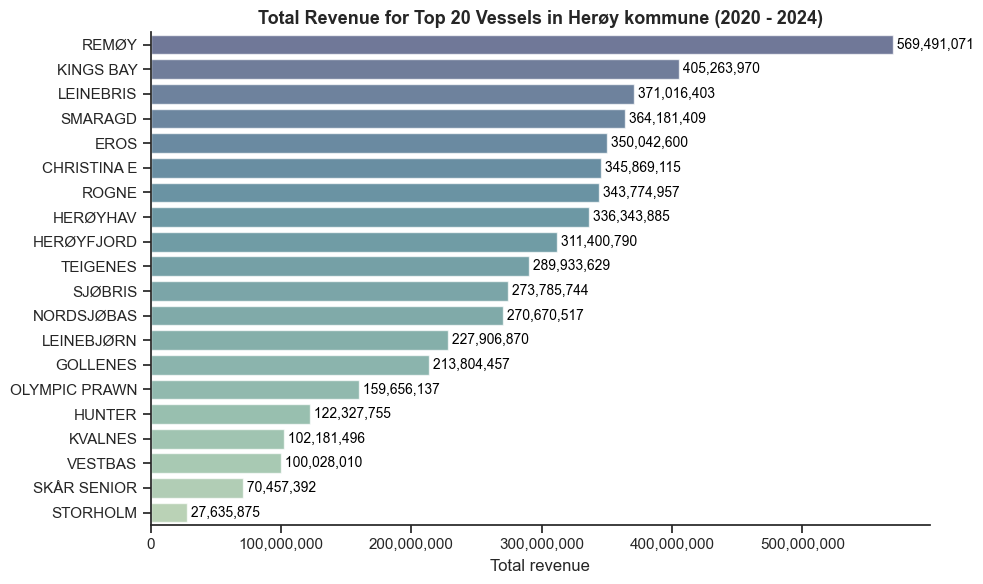

In [152]:
# Create a horizontal bar chart for total catch (Rundvekt)
plt.figure(figsize=(10,6))
sns.barplot(data=pandas_revenue, y='Fartøynavn', x='Total fangstverdi', hue='Fartøynavn', palette='crest_r', alpha=0.7)

# Customize tick labels to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Adding
for index, value in enumerate(pandas_revenue['Total fangstverdi']):
    plt.text(value, index, f' {value:,.0f}', ha='left', va='center', color='black', fontsize=10)


sns.despine()

# Labels and titles
plt.title('Total Revenue for Top 20 Vessels in Herøy kommune (2020 - 2024)', fontdict={'fontsize' : 13, 'fontweight':'semibold'})
plt.ylabel('')
plt.xlabel('Total revenue', labelpad=5)

plt.tight_layout()

### **A closer look at categorical data for all vessels**

As can be seen from the 'Round weight' barplot above, there is a big gap between 'SJØBRIS' and 'SKÅR SENIOR', so to get a better comparison we will focus on the top 12 vessels to avoid affecting descriptive statistical calculations too much.

In [153]:
# Get the names of the top 'Fartøynavn' with a similar round weight
top_vessels_names = top_20_df.limit(13).select('Fartøynavn').distinct().collect()

In [154]:
# Check we collected the correct vessels
vessel_names = [row.Fartøynavn for row in top_vessels_names]

vessel_names

['KINGS BAY',
 'SMARAGD',
 'EROS',
 'HERØYFJORD',
 'ROGNE',
 'NORDSJØBAS',
 'CHRISTINA E',
 'HERØYHAV',
 'GOLLENES',
 'TEIGENES',
 'LEINEBJØRN',
 'SJØBRIS',
 'REMØY']

In [155]:
# Filtering by specific vessels
filtered_df = df_overview.filter(col('Fartøynavn').isin(vessel_names))

In [156]:
# Save the top 13 vessels in a PySpark dataframe
top_13 = filtered_df

# Converting to pandas DataFrame
top_13_pandas = top_13.toPandas()

In [157]:
# Double check that only the 13 specified 'Fartøynavn' were included
top_13_pandas['Fartøynavn'].nunique()

13

##### **Seasonality - Round weight by month**

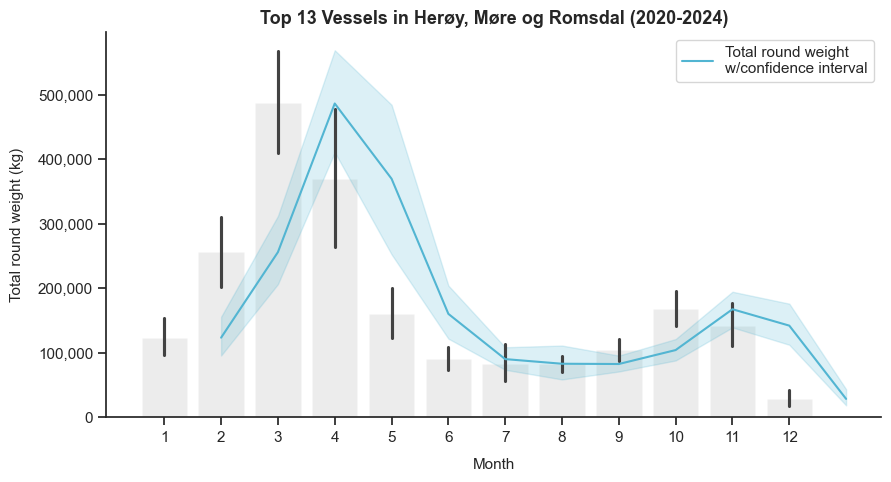

In [198]:
plt.figure(figsize=(10,5))
sns.barplot(data=top_13_pandas, x='Fangstmåned', y='Total rundvekt', color='grey', alpha=0.15)
sns.lineplot(data=top_13_pandas, x='Fangstmåned', y='Total rundvekt', color='#52b5d2', label='Total round weight \nw/confidence interval')

# Customize tick labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Plot labels
plt.title('Top 13 Vessels in Herøy, Møre og Romsdal (2020-2024)', fontdict={'fontsize' : 13, 'fontweight':'semibold'})
plt.ylabel('Total round weight (kg)', labelpad=10, fontdict={'fontsize' : 11})
plt.xlabel('Month', labelpad=10, fontdict={'fontsize' : 11})
plt.legend()

##### **Revenue & price**

We want to explain the differences in total revenue using the data, and find out why Remøy makes more than it's competitors. Specific species is known to be more expensive.

Here we can see that Remøy focuses on catches that generate higher income per catch.

C:\Users\sarah\AppData\Local\Temp\ipykernel_13512\3434682808.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_13_pandas, x='Enhetspris for fisker', y='Fartøynavn', palette='crest_r', alpha=0.7)


Text(0, 0.5, 'Vessels')

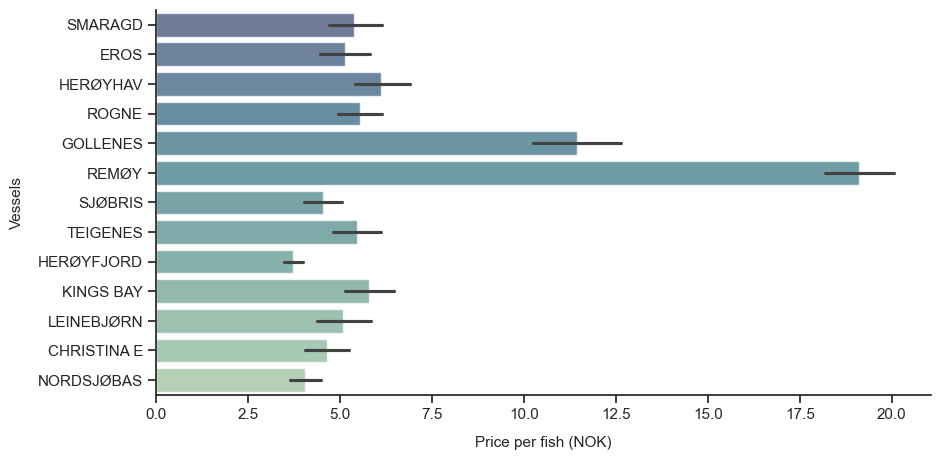

In [173]:
plt.figure(figsize=(10,5))

# Plotting price per unit for each vessel
sns.barplot(data=top_13_pandas, x='Enhetspris for fisker', y='Fartøynavn', palette='crest_r', alpha=0.7)
plt.xlabel('Price per fish (NOK)', labelpad=10, fontdict={'fontsize' : 11})
plt.ylabel('Vessels', labelpad=10, fontdict={'fontsize' : 11})


C:\Users\sarah\AppData\Local\Temp\ipykernel_13512\2600747967.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_fish, x='Average enhetspris for fisker', y='Art FAO', palette='crest_r', alpha=0.7)


Text(0, 0.5, 'Species (Norwegian)')

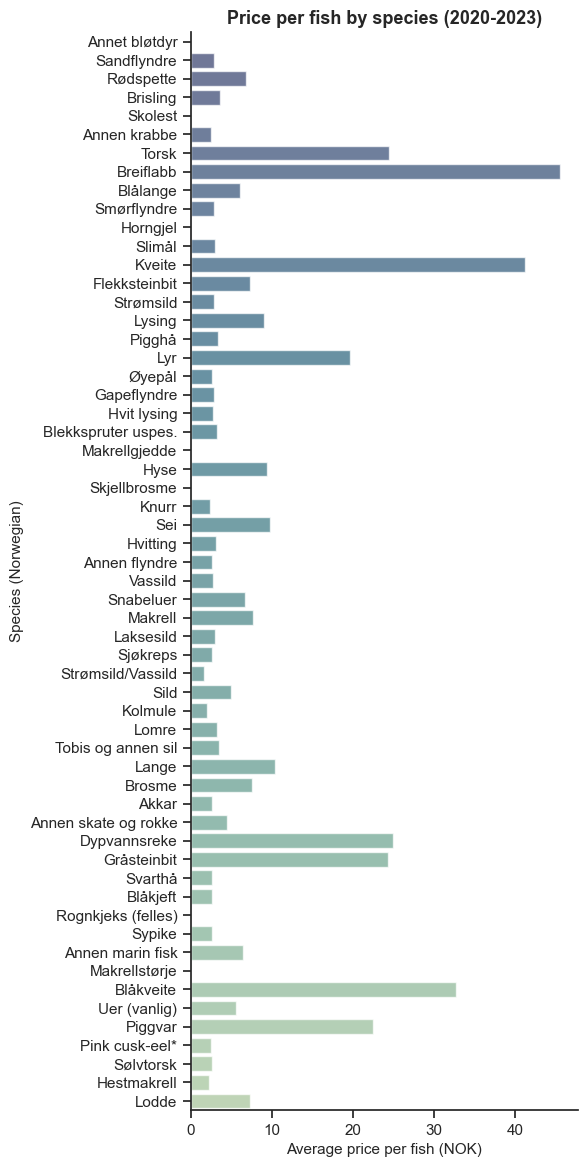

In [197]:
# Get a list of distinct types of Art FAO found in the catch data of the top 13 vessels
fish_list = top_13.select('Art FAO').distinct().collect()

# Get each row in the fish_list
fish_list = [row['Art FAO'] for row in fish_list]

# Filter the DataFrame by the species found in fish_list
fish_species = top_13.filter(col('Art FAO').isin(fish_list))

# Group the species by their average price
avg_fish_price = fish_species.groupBy('Art FAO').agg(
    avg('Enhetspris for fisker').alias('Average enhetspris for fisker'))

# Convert to pandas DataFrame
avg_fish = avg_fish_price.toPandas()

# Barplot
plt.figure(figsize=(5,14))
sns.barplot(data=avg_fish, x='Average enhetspris for fisker', y='Art FAO', palette='crest_r', alpha=0.7)

plt.title('Price per fish by species (2020-2023)', fontdict={'fontsize' : 13, 'fontweight':'semibold'})
plt.xlabel('Average price per fish (NOK)', fontdict={'fontsize' : 11})
plt.ylabel('Species (Norwegian)', fontdict={'fontsize' : 11})

#### **Remøy vs. Smaragd - vessel comparison between the top and one of the top 10-performing vessels**

Here we want to get a closer look to explain where the differences come from. We pick the vessel with the highest revenue, and another among the top 10.

In [160]:
# Saving data to compare a vessel to the one with the top revenue ('Fangstverdi)
remøy_smaragd = top_13.filter(col('Fartøynavn').isin(['SMARAGD', 'REMØY']))

##### **Seasonality - during which season do they catch the most?**

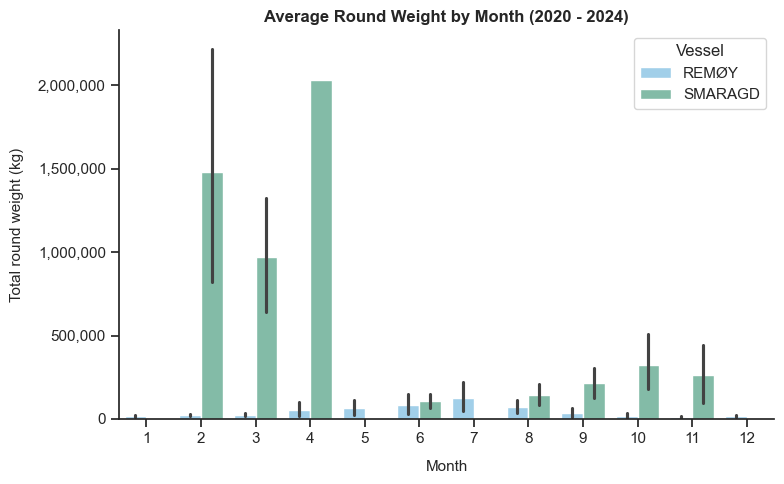

In [192]:
plt.figure(figsize=(8,5))

# Convert to pandas DataFrame
remøy_smaragd_pandas = remøy_smaragd.toPandas()

sns.barplot(data=remøy_smaragd_pandas, x='Fangstmåned', y='Total rundvekt', hue='Fartøynavn', palette={'REMØY': '#95d2f5', 'SMARAGD': '#7ac4a9'})

# Customize tick labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.despine()

# Labels and titles
plt.title('Average Round Weight by Month (2020 - 2024)', fontdict={'fontsize' : 12, 'fontweight':'semibold'})
plt.ylabel('Total round weight (kg)', labelpad=10, fontdict={'fontsize' : 11})
plt.xlabel('Month', labelpad=10, fontdict={'fontsize' : 11})
plt.legend(title='Vessel')

plt.tight_layout()

Here we can clearly see Smaragd catches a lot more fish (by weight). An increased revenue for Remøy indicates their catch generates more income per catch - so we want to check what they catch.

##### **Which areas did Smaragd and Remøy visit the most?**

This data shows how their catch is area-specific.

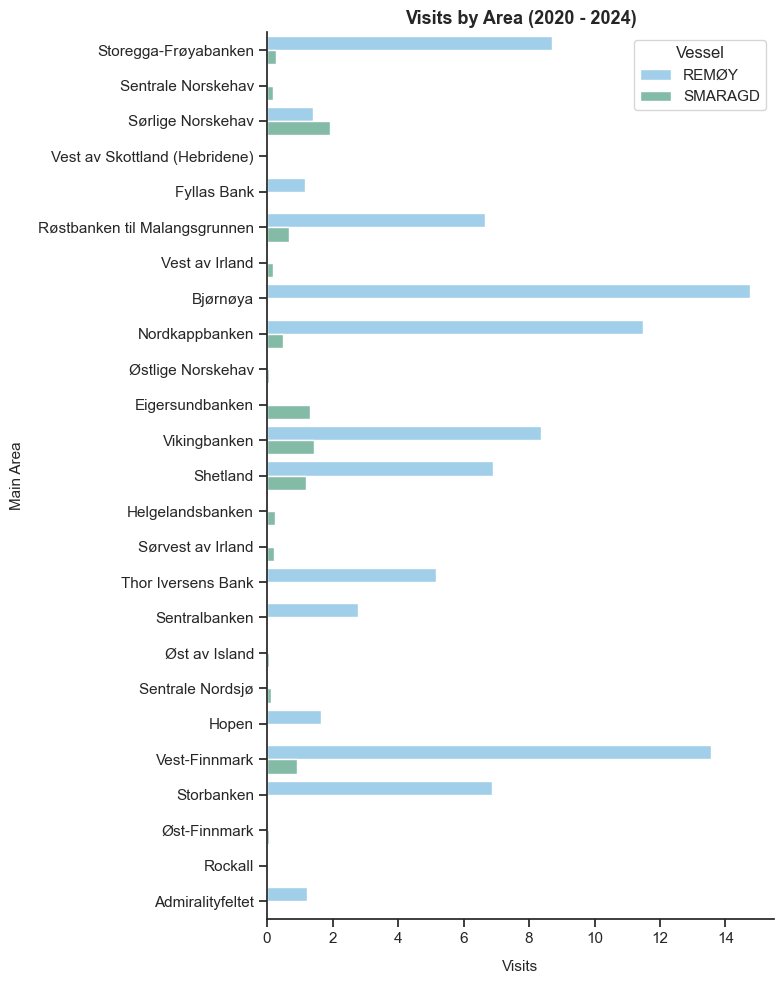

In [185]:
# Group visit counts by main area ('Hoverområde')
remøy_smaragd_grouped = remøy_smaragd.groupBy('Fartøynavn', 'Hovedområde').agg(F.sum('Besøk').alias('Total visits'))

# Count the total amount of visits per vessel
global_total = remøy_smaragd.agg(F.sum('Besøk').alias('Global total')).collect()[0]['Global total']

# Convert the Total visits count to percentage based values
remøy_smaragd_grouped = remøy_smaragd_grouped.withColumn('Percentage', (F.col('Total visits')/global_total)*100).toPandas()

plt.figure(figsize=(8,10))

sns.barplot(data=remøy_smaragd_grouped, x='Percentage', y='Hovedområde', hue='Fartøynavn', palette={'REMØY': '#95d2f5', 'SMARAGD': '#7ac4a9'})

# Labels and titles
plt.title('Visits by Area (2020 - 2024)', fontdict={'fontsize' : 13, 'fontweight':'semibold'})
plt.ylabel('Main Area', labelpad=10, fontdict={'fontsize' : 11})
plt.xlabel('Visits', labelpad=10, fontdict={'fontsize' : 11})
plt.legend(title='Vessel')

plt.tight_layout()

##### **Revenue by species - which species make up most of their revenue?**

Here we can clearly see the specifics. Remøy focuses on white fish (known to fetch a higher price) and prawns amongst other things. Smaragd, on the other hand, brings in their revenue based on large amounts of other species of fish that fects a lower price, mainly 'lodde', 'sild', 'makrell' and 'kolmule'.

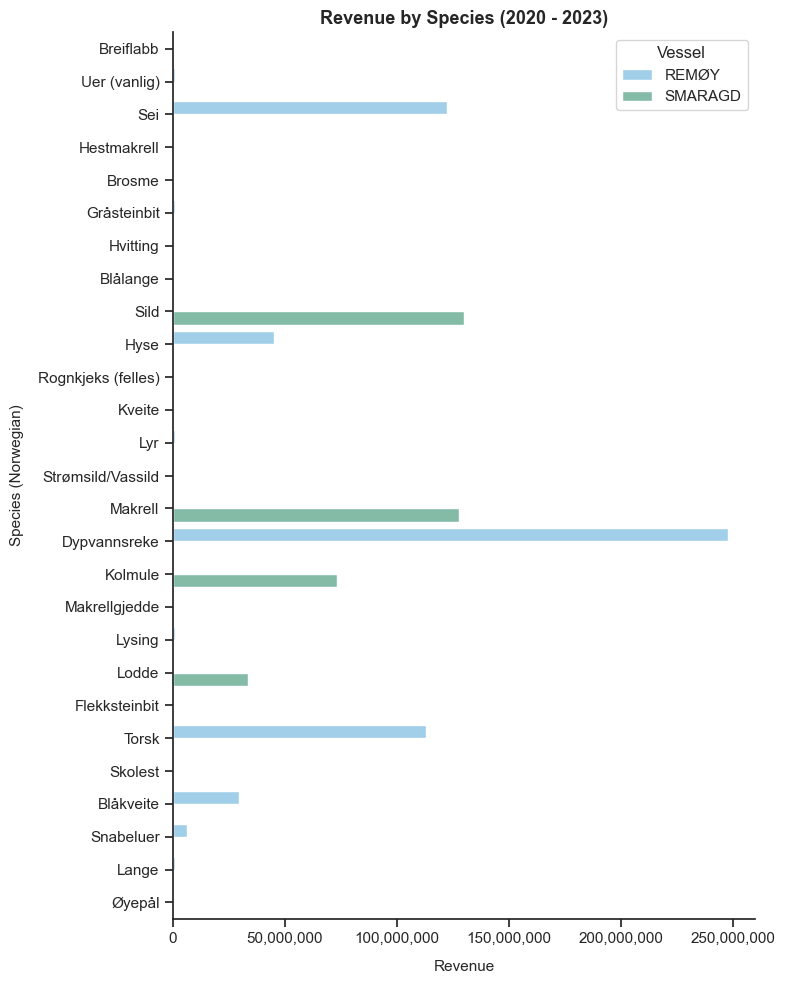

In [184]:
plt.figure(figsize=(8,10))

remøy_smaragd_revenue = remøy_smaragd.groupBy('Fartøynavn', 'Art FAO').agg(F.sum(col('Total fangstverdi')).alias('Sum fangstverdi')).toPandas()

sns.barplot(data=remøy_smaragd_revenue, x='Sum fangstverdi', y='Art FAO', hue='Fartøynavn', palette={'REMØY': '#95d2f5', 'SMARAGD': '#7ac4a9'})

# Customize tick labels to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Labels and titles
plt.title('Revenue by Species (2020 - 2023)', fontdict={'fontsize' : 13, 'fontweight':'semibold'})
plt.ylabel('Species (Norwegian)', labelpad=10, fontdict={'fontsize' : 11})
plt.xlabel('Revenue', labelpad=10, fontdict={'fontsize' : 11})
plt.legend(title='Vessel')

plt.tight_layout()

### **Heatmapping for total data overview**

To conclude, let's map an overview of the entire dataset. <br>

As some values are expected to have a linear relationship ('Total fangstverdi' and 'Total rundvekt'), other values could be affected by seasonality between months. A Spearman correlation might be the better pick here, but a combination of Pearson or Spearman could give insightful information. A violin plot or Q-Q plots can tell us more about the data distribution. If it appears to be normally distributed, Pearson might be the better pick.

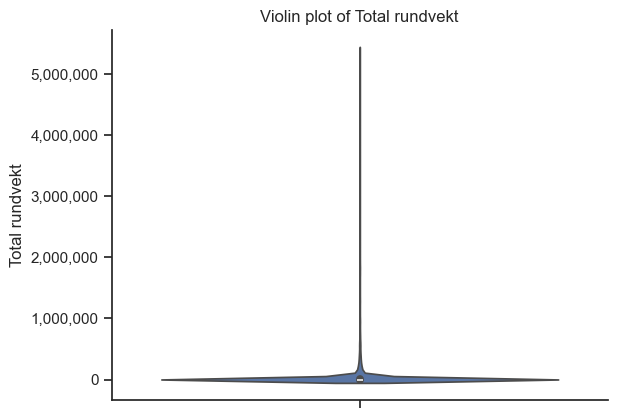

In [186]:
# Violin plot
sns.violinplot(y=df_overview_pandas['Total rundvekt'])
plt.title('Violin plot of Total rundvekt')

# Customize tick labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

The QQ-plot shows how the round weight data deviates significantly from the straight diagonal line, and we can safely say the data isn't normally distributed

Text(0.5, 1.0, 'Q-Q Plot of Total rundvekt')

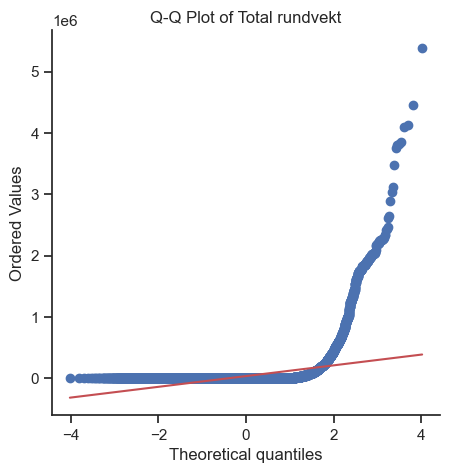

In [166]:
data = df_overview_pandas['Total rundvekt']

# Q-Q plot
plt.figure(figsize=(5,5))
stats.probplot(data, dist='norm', plot=plt)
plt.title('Q-Q Plot of Total rundvekt')

In [167]:
# Creating a Spearman correlation matrix for the overall data
spearman_matrix = df_overview_pandas.corr(method='spearman', numeric_only=True).round(3)

spearman_matrix

,Fangstår,Fangstmåned,Enhetspris for fisker,Besøk,Total rundvekt,Total fangstverdi
Fangstår,1.000,-0.118,0.167,0.131,-0.023,0.009
Fangstmåned,-0.118,1.000,-0.033,-0.078,0.086,0.032
Enhetspris for fisker,0.167,-0.033,1.000,-0.010,-0.054,0.263
Besøk,0.131,-0.078,-0.010,1.000,0.100,0.103
Total rundvekt,-0.023,0.086,-0.054,0.100,1.000,0.768
Total fangstverdi,0.009,0.032,0.263,0.103,0.768,1.000


**The heatmap shows us what we have discovered from the data analysis:**
- The total round weight ('Total rundvekt') heavily affects the total revenue ('Total fangstverdi')
- The price per fish/species ('Enhetspris for fisker') caught correlates with the revenue
- The round weight was higher ('Rundvekt') during certain months ('Måned')
- Some other points include:
    - There were more trips for each vessel ('Besøk') depending on the year
    - The unit price per fish ('Enhetspris for fisker') varied per year

<Axes: >

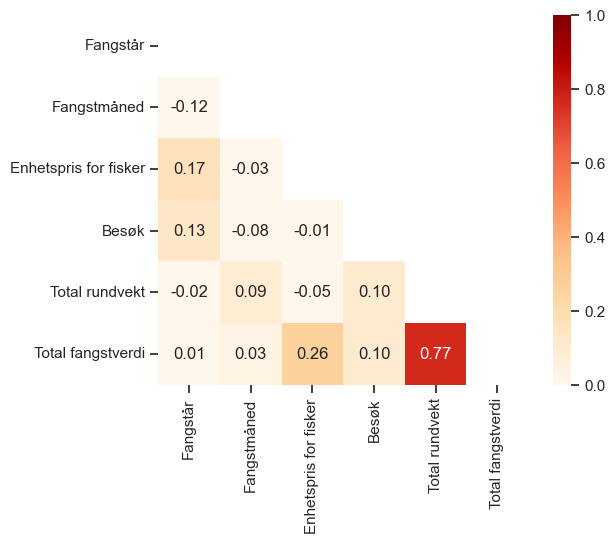

In [168]:
# Creating a mask for the heatmap, so only half of it shows (as it is mirrored)
mask = np.triu(np.ones_like(spearman_matrix, dtype=bool))

# Creating a heatmap from the total data overview
sns.heatmap(spearman_matrix, cmap='OrRd', vmin=0, vmax=1, annot=True, fmt='0.2f', square=True, mask=mask)